## Transfer Learning : Models as Feature Extractors

#### Import Required Packages

In [24]:
from keras.applications import VGG16, imagenet_utils
from keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import LabelEncoder
from drig.feature.feature import FeatureCondenser
from imutils import paths
import numpy as np
import progressbar
import os
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pickle

#### Initialise CalTech-101 Dataset & Feature File Path 

In [41]:
dataset_path=os.path.abspath(os.path.join(os.pardir,"datasets/101_ObjectCategories/"))
feature_file_path=os.path.abspath(os.path.join(os.pardir,"datasets/101_ObjectCategories/vgg16_fetaure.hdf5"))
output_model_path=os.path.abspath(os.path.join(os.pardir,"models/caltech101_tranfered.cpickle"))

#### Initialise Image Data from Disk, shuffle Images & get Labels  

In [11]:
image_paths=list(paths.list_images(dataset_path))
random.shuffle(image_paths)
labels=[image_path.split("/")[-2] for image_path in image_paths]


#### One Hot Encode Labels

In [12]:
label_encoder=LabelEncoder()
labels=label_encoder.fit_transform(labels)

#### Import Pre-Trained VGG16 with Disconnected FC

In [13]:
feature_extractor=VGG16(weights="imagenet", include_top=False)

#### Initialise Buffer Size & Batch Size

In [14]:
buffer_size=1000
batch_size=32

#### Initialise Feature Condenser

In [15]:
feature_dataset=FeatureCondenser((len(image_paths),512*7*7),feature_file_path,group_name="features", buffer_size=buffer_size)

#### Save Class Labels in Feature Dataset

In [16]:
feature_dataset.save_class_names(label_encoder.classes_)

#### Function To Prepare Image for Feature Extraction through VGG16

In [17]:
def preprocess_image(image_path):
    try:
        image_array=img_to_array(load_img(image_path, target_size=(224,224)))
        image_array=np.expand_dims(image_array, axis=0)
        preprocessed_image=imagenet_utils.preprocess_input(image_array)
        return preprocessed_image
    except Exception as e:
        print(e)

#### Function Run Batch Prediction To Extract Features & Save in Feature Dataset

In [18]:
def process_batch(index, image_paths, batch_size, feature_extractor, prog_bar):
    try:
        global feature_dataset
        batch_image_paths=image_paths[index:index+batch_size]
        batch_labels=labels[index:index+batch_size]
        batch_images=[preprocess_image(image_path) for image_path in batch_image_paths]
        model_batch_images=np.vstack(batch_images)    
        features=feature_extractor.predict(model_batch_images, batch_size=batch_size)    
        features=features.reshape((features.shape[0], 7*7*512))
        feature_dataset.commit(features, batch_labels)
        prog_bar.update(index)
        
    except Exception as e:
        print(e)

#### Run Batch Predictions on Model to get Features

In [19]:
widgets=["Extracting Features:", progressbar.Percentage()," ",progressbar.Bar()," ", progressbar.ETA()]
prog_bar=progressbar.ProgressBar(max_value=len(image_paths),widgets=widgets).start()
_=[process_batch(index, image_paths, batch_size, feature_extractor, prog_bar) for index in np.arange(0,len(image_paths),batch_size)]
feature_dataset.lock()
prog_bar.finish()

Extracting Features:100% |#####################################| Time:  0:05:22


#### Let's look at our feature dataset

In [28]:
import h5py
vgg16_caltech_features=h5py.File(feature_file_path,mode="r")
list(vgg16_caltech_features.keys())

['class_labels', 'features', 'labels']

#### Get train-test split index`

In [29]:
training_set_index=int(vgg16_caltech_features["labels"].shape[0]*0.75)

#### Train Logistic Regressor on Extracted Features
#####  -we tune the "strictness" hyper-param to its best value.

In [30]:
strictness=dict(C=[0.1,1.0,10.0,100.0,1000.0,10000.0])
model=GridSearchCV(LogisticRegression(), strictness, cv=3, n_jobs=-1)
model.fit(vgg16_caltech_features["features"][:training_set_index],vgg16_caltech_features["labels"][:training_set_index])

/Users/suyashsrivastava/miniforge3/envs/dl4cv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]})

#### Let's check the best value for hyper-param obtained

In [32]:
print(f"Best Param : {model.best_params_}")

Best Param : {'C': 0.1}


#### Running Prediction on Test Data

In [ ]:
predictions=model.predict(vgg16_caltech_features["features"][training_set_index:])

#### Evaluating Model

In [35]:
print(classification_report(vgg16_caltech_features["labels"][training_set_index:], predictions, target_names=vgg16_caltech_features["class_labels"]))

                 precision    recall  f1-score   support

          Faces       0.97      0.99      0.98       103
     Faces_easy       0.98      0.98      0.98       120
       Leopards       0.86      1.00      0.92        43
     Motorbikes       1.00      1.00      1.00       224
      accordion       1.00      1.00      1.00        21
      airplanes       1.00      1.00      1.00       199
         anchor       1.00      1.00      1.00         9
            ant       0.82      0.64      0.72        14
         barrel       1.00      0.90      0.95        10
           bass       1.00      0.94      0.97        16
         beaver       0.89      0.67      0.76        12
      binocular       1.00      1.00      1.00         3
         bonsai       0.97      0.97      0.97        32
          brain       0.96      1.00      0.98        22
   brontosaurus       0.90      0.82      0.86        11
         buddha       0.96      1.00      0.98        25
      butterfly       0.94    

#### Write Model To Disk

In [38]:
f=open(output_model_path),"wb")
f.write(pickle.dumps(model.best_estimator_))
f.close()
vgg16_caltech_features.close()

#### Running Random Predictions

In [78]:
from keras.applications import VGG16, imagenet_utils
from keras.preprocessing.image import img_to_array, load_img
import pickle
import random
import cv2
vgg16_image_net_model=VGG16(weights="imagenet", include_top=False)

In [89]:
query_image_path=random.choice(image_paths)
quey_image_array=img_to_array(load_img(query_image_path, target_size=(224,224)))        
quey_image_array=np.expand_dims(quey_image_array, axis=0)
query_preprocessed_image=imagenet_utils.preprocess_input(quey_image_array)

In [90]:
image_features=vgg16_image_net_model.predict(query_preprocessed_image)
image_features=image_features.reshape((image_features.shape[0],7*7*512))

In [91]:
logregress_model=pickle.load(open(output_model_path,"rb"))

In [92]:
prediction=logregress_model.predict(image_features)

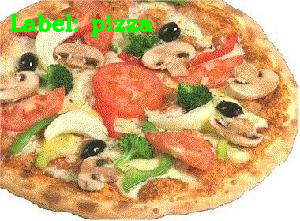

In [93]:
from drig.utils import display_prediction
display_prediction(query_image_path, prediction, label_encoder.classes_)